# Proximity analysis
In this notebook we will be working with data from [OpenStreetMap](https://openstreetmap.org) to do proximity analysis to various urban amenities.

In [33]:
import geopandas
from matplotlib.colors import ListedColormap
import pyproj
from shapely.ops import transform

%matplotlib inline

## Import data

In [2]:
food_sources_file = "data/Tampere-food_sources.geojson"
bus_stops_file = "data/Tampere-bus_stops.gpkg"
building_footprints_file = "data/Tampere-buildings.gpkg"

In [3]:
food_sources = geopandas.read_file(food_sources_file)
bus_stops = geopandas.read_file(bus_stops_file)
buildings = geopandas.read_file(building_footprints_file)

In [4]:
food_sources.shape

(55, 6)

In [5]:
bus_stops.shape

(737, 5)

In [6]:
buildings.shape

(16433, 6)

## Use OSM for GeoDataFrame index

In [7]:
buildings.set_index("osm_id", inplace=True, verify_integrity=True)
bus_stops.set_index("osm_id", inplace=True, verify_integrity=True)
food_sources.set_index("osm_id", inplace=True, verify_integrity=True)

## Building centroids

In [8]:
buildings["centroid"] = buildings["geometry"].centroid

In [9]:
buildings.head()

,code,fclass,name,type,geometry,centroid
osm_id,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055)
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709)
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620)
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543)
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104)


In [10]:
buildings.rename(
    columns={
        "geometry": "footprint",
        "centroid": "geometry"
    }, 
    inplace=True
)

In [11]:
buildings.head()

,code,fclass,name,type,footprint,geometry
osm_id,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055)
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709)
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620)
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543)
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104)


In [12]:
buildings.dtypes

code            int64
fclass         object
name           object
type           object
footprint    geometry
geometry     geometry
dtype: object

## Create buffers

### Food sources

In [13]:
buffer_distance_m = 1000

food_sources_buffered = food_sources.buffer(buffer_distance_m)

type(food_sources_buffered)

geopandas.geoseries.GeoSeries

### Bus stops

In [41]:
%%time
buffer_distance_m = 250

bus_stops_buffered = bus_stops.buffer(buffer_distance_m)

CPU times: user 179 ms, sys: 0 ns, total: 179 ms
Wall time: 178 ms


## Dissolve buffers

### Food sources

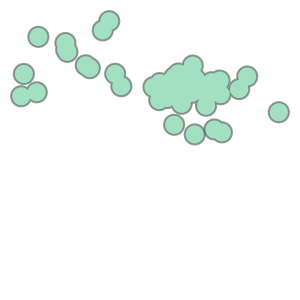

In [16]:
food_sources_catchment = food_sources_buffered.unary_union
food_sources_catchment

### Bus stops

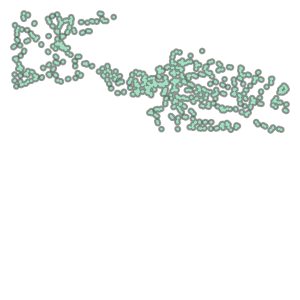

In [17]:
bus_stops_catchment = bus_stops_buffered.unary_union
bus_stops_catchment

## Access to amenities

CPU times: user 52.4 ms, sys: 0 ns, total: 52.4 ms
Wall time: 51.4 ms


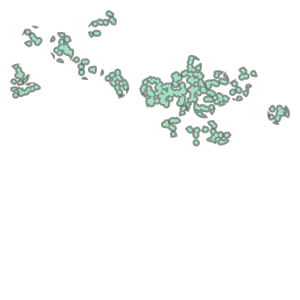

In [18]:
%%time
access_to_amenities = bus_stops_catchment.intersection(food_sources_catchment)
access_to_amenities

## Buildings within food catchment

In [19]:
%%time
buildings["within_food_catchment"] = buildings.within(food_sources_catchment)

CPU times: user 8.84 s, sys: 0 ns, total: 8.84 s
Wall time: 8.84 s


In [20]:
%%time
buildings["access_to_amenities"] = buildings.within(access_to_amenities)

CPU times: user 1min 14s, sys: 0 ns, total: 1min 14s
Wall time: 1min 14s


In [21]:
buildings.head()

,code,fclass,name,type,footprint,geometry,within_food_catchment,access_to_amenities
osm_id,,,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055),True,True
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709),False,False
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620),True,True
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543),True,True
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104),True,False


### Visual representation

In [38]:
colormap = ListedColormap(["firebrick", "forestgreen"])

<AxesSubplot:>

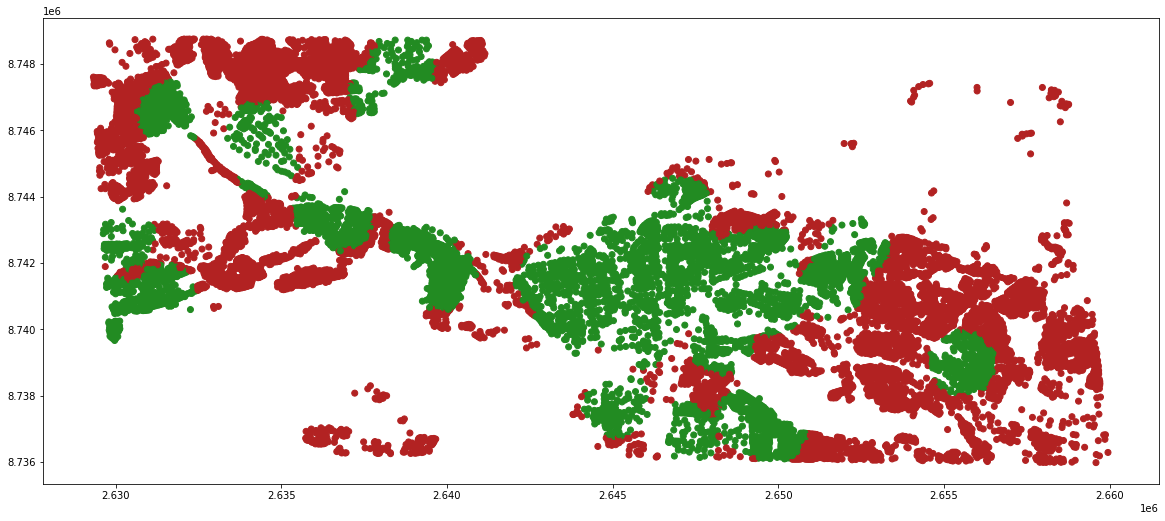

In [39]:
buildings.plot(categorical=True, column="within_food_catchment",figsize=(20, 15), cmap=colormap)

<AxesSubplot:>

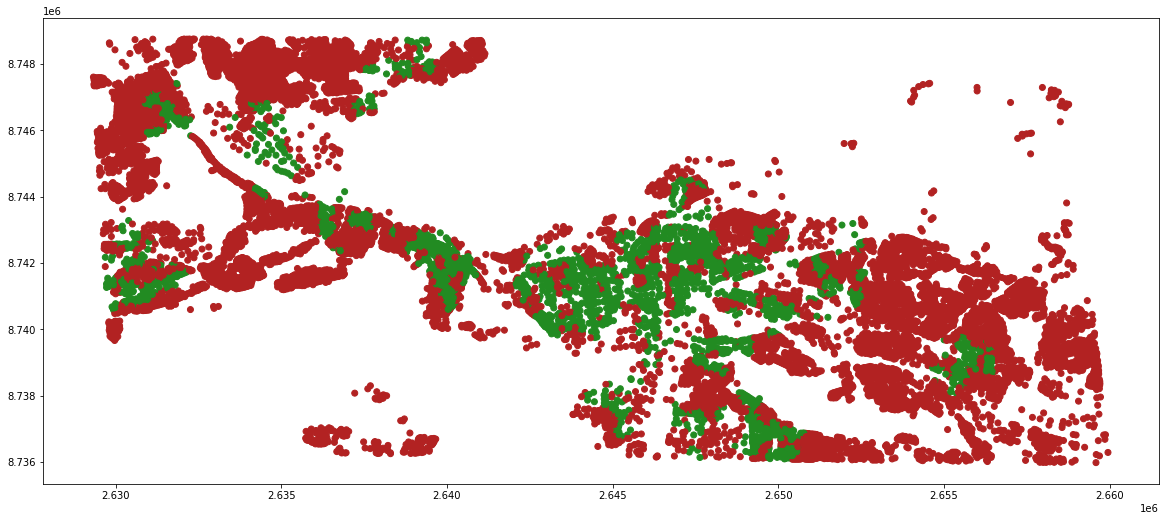

In [40]:
buildings.plot(categorical=True, column="access_to_amenities",figsize=(20, 15), cmap=colormap)

### Proportional representation

In [24]:
buildings.head()

,code,fclass,name,type,footprint,geometry,within_food_catchment,access_to_amenities
osm_id,,,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055),True,True
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709),False,False
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620),True,True
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543),True,True
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104),True,False


In [25]:
buildings["access_to_amenities"].value_counts(normalize=True)

False    0.795716
True     0.204284
Name: access_to_amenities, dtype: float64